In [1]:
#
# This notebook is for the exploration of Logistic Regression -- it corresponds to handout-02
# https://frcs.github.io/4C16-LectureNotes/logistic-regression.html
#

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-02/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-02


In [3]:
# Autoload setup (you don't need to edit this cell); instructions to:
import importlib
import lab_2

In [4]:
##############################################################
#
# 1: import
#
##############################################################

import pandas as pd        # for datasets
import numpy as np         # for linear algebra
from tqdm import tqdm      # for progress bars

import matplotlib as mpl   # for plotting graphs
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

%matplotlib inline


In [5]:
# sets default style for graphs

plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1.7
plt.rcParams["figure.figsize"] = (10,6)


In [6]:
##############################################################
#
# 2. loading the ISLR 'Default' dataset
#
##############################################################

# see https://cran.r-project.org/web/packages/ISLR/ISLR.pdf
#
# This data set contains information on ten thousand customers.
#
# The aim here is to predict which customers will default on their credit card debt.
#
# The dataset contains 10000 observations on the following 4 variables.
#   * 'default': a No/Yes label indicating whether the customer defaulted on their debt
#   * 'student': a No/Yes label indicating whether the customer is a student
#   * 'balance': the average balance that the customer has remaining on their credit card after making
#                their monthly payment
#   * 'income' : income of customer

df = pd.read_csv('Default.csv')

# we are using here the pandas python package to read the CSV file.
# we can look at the first 10 observations

df.head(10)

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625070
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138950
3,4,No,No,529.250605,35704.493940
4,5,No,No,785.655883,38463.495880
5,6,No,Yes,919.588531,7491.558572
6,7,No,No,825.513331,24905.226580
7,8,No,Yes,808.667504,17600.451340
8,9,No,No,1161.057854,37468.529290
9,10,No,No,0.000000,29275.268290


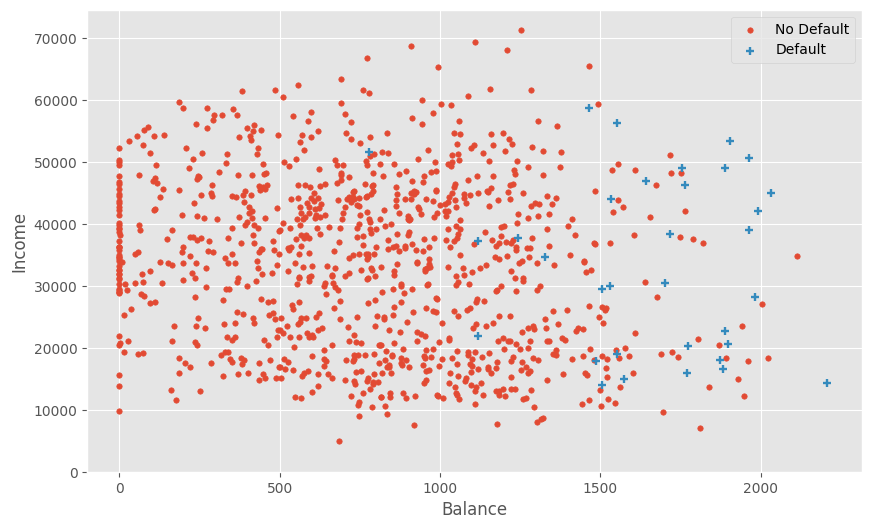

In [7]:
##############################################################
#
# 3. visualise your data
#
##############################################################

# We need to visualise our data
# let's ignore the categorical features 'student' and the first column
# and focus on the 'balance' and 'income' features

balance = df['balance'].values
income = df['income'].values

# the outcome is of boolean type, converting it to vector of integers
y = (df['default'].values == 'Yes').astype(int)

# we are only going to plot a subset of the data
income_subset = income[0:1000];
balance_subset = balance[0:1000];
y_subset = y[0:1000];

# plotting balance vs income for the 'No Default' class
plt.scatter(balance_subset[y_subset == 0],
            income_subset[y_subset == 0],
            s=15, marker='o')

# plotting balance vs income for the 'Default' class
plt.scatter(balance_subset[y_subset == 1],
            income_subset[y_subset == 1],
            s=40, marker='+')

plt.ylim(ymin=0)
plt.ylabel('Income')
plt.xlim(xmin=-100)
plt.xlabel('Balance')
plt.legend(['No Default', 'Default'])
plt.show()

# after a quick look at the graph, it appears that
# the most relevant feature is 'balance'


In [33]:
# Exercise 1: implement cross-entropy (in the lab_2 module)

# Import lab_2 again
importlib.reload(lab_2)

w_test = np.array([[0.1], [0.3]])
X_test = np.array([[1,1], [1,0], [3,2]])
y_test = np.array([[0], [1], [1]])
print(lab_2.cross_entropy(w_test, X_test, y_test))

# Should print 0.632853327993248 if your function is working.

0.6328549892097132


In [36]:
# Exercise 2: implement gradient computation (in the lab_2 module)
# Import lab_2 again
importlib.reload(lab_2)


w_test = np.array([0.1, 0.3])
X_test = np.array([[1,1], [1,0]])
y_test = np.array([0, 1])
print(lab_2.gradient(w_test, X_test, y_test))
# Expected result: [ 0.06183342  0.29934383]

[0.06183342 0.29934383]


In [37]:
# The gradient descent algorithm as explained in lecture notes
# the learning_rate refers to the greek letter 'eta'
# The method also returns the vectors of
#   loss function, sampled iterations, weights
# Import lab_2 again
importlib.reload(lab_2)

def gradient_descent(w0, X, y, learning_rate=0.01, maxit=1000):
    print("starting gradient descent")
    w = w0
    n = X.shape[0]
    p = X.shape[1]
    step = 83 # interval between measures
    m = (maxit // step) + 1 # nb of checks
    loss = np.zeros((m,1))
    its = np.zeros((m,1))
    ws = np.zeros((m,p))

    for i in tqdm(range(0, maxit)):
        # monitoring the loss at regular intervals
        if (i % step == 0):
            j = i // step
            loss[j] = lab_2.cross_entropy(w, X, y)
            its[j] = i
            ws[j,0:p] = w.ravel()

        # computing the loss gradient
        grad = lab_2.gradient(w,X,y);

        # updating the weights
        w = w - learning_rate * grad;
        i = i + 1
    return w, loss, its, ws


(10000, 2)
(10000, 2)
starting gradient descent


 25%|██▌       | 1269/5000 [00:01<00:02, 1262.22it/s]/content/gdrive/MyDrive/4c16-labs/code/lab-02/lab_2.py:57: RuntimeWarning: invalid value encountered in log
  ce = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
100%|██████████| 5000/5000 [00:03<00:00, 1252.35it/s]


[-6547.44035814  -687.98843417]


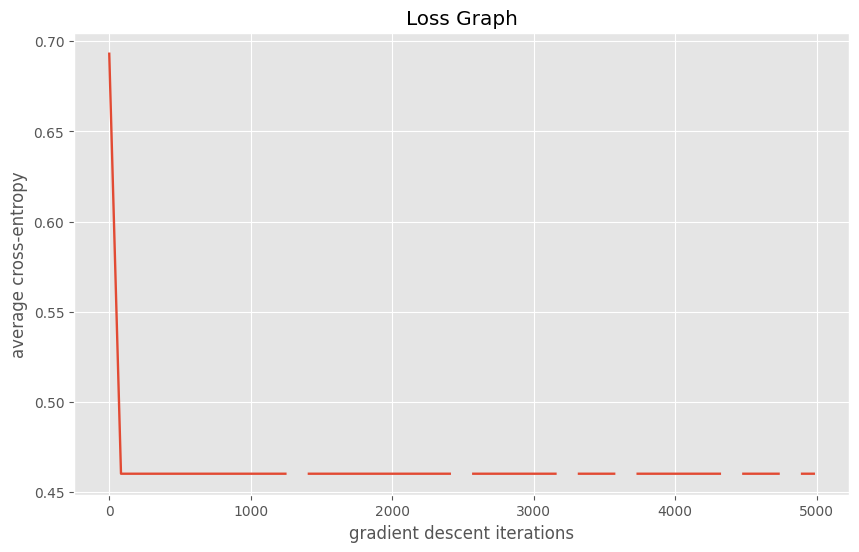

In [38]:
#
# Setting up the Model and Design Matrix
#
# in this lab we will look at the following model:
# y = [ w0 + w1 * balance > 0]
#
# and ignore the 'income' feature

n = balance.shape[0]  # number of observations
p = 2                 # number of features

X = np.zeros(shape=(n, p))
print(X.shape)

# the first feature is 1 (with associated weight w0)
X[:,0] = 1;

# the second feature is the balance values (with associated weight w1)
X[:,1] = balance[:]
print(X.shape)

# initial weights
w0 = np.array([0,0]);

# starting gradient descent optimisation with some default parameters
w, loss, its, ws = gradient_descent(w0, X, y, learning_rate=40, maxit=5000);
print(w)

# plot of the loss graph, ie.
plt.plot(its, loss)
plt.title("Loss Graph")
plt.xlabel('gradient descent iterations')
plt.ylabel('average cross-entropy')
plt.show()


In [39]:
# if you look carefully, you will find that the gradient descent is not working
# very well. You can see this because the overall loss is not going down, oscillates
# and never gets low enough (eg. avg cross-entropy > .5, when we would like something < 0.1)

In [40]:
# to better study the convergence issues, we'll also plot the weights
# we encapsulate all these plots a single function:

def plot_loss_graph_and_weight_evolution(loss, ws, its):

  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

  f.set_figheight(15)
  f.set_figwidth(15)

  ax1.plot(its, loss)
  ax1.set_xlabel('gradient descent iterations')
  ax1.set_ylabel('average cross-entropy')

  ax2.plot(ws[:,0], ws[:,1],
          color='g', marker='o',
          linestyle='dashed', linewidth=0.5, markersize=4)
  ax2.set_title('Evolution of the Weights')
  ax2.set_xlabel('$w_0$')
  ax2.set_ylabel('$w_1$')

  ax3.plot(its, ws[:,0], 'g-')
  ax3.set_title('Evolution of $w_0$')
  ax3.set_xlabel('gradient descent iterations')
  ax3.set_ylabel('$w_0$')

  ax4.plot(its, ws[:,1], 'g-')
  ax4.set_title('Evolution of $w_1$')
  ax4.set_xlabel('gradient descent iterations')
  ax4.set_ylabel('$w_1$')

  plt.show()

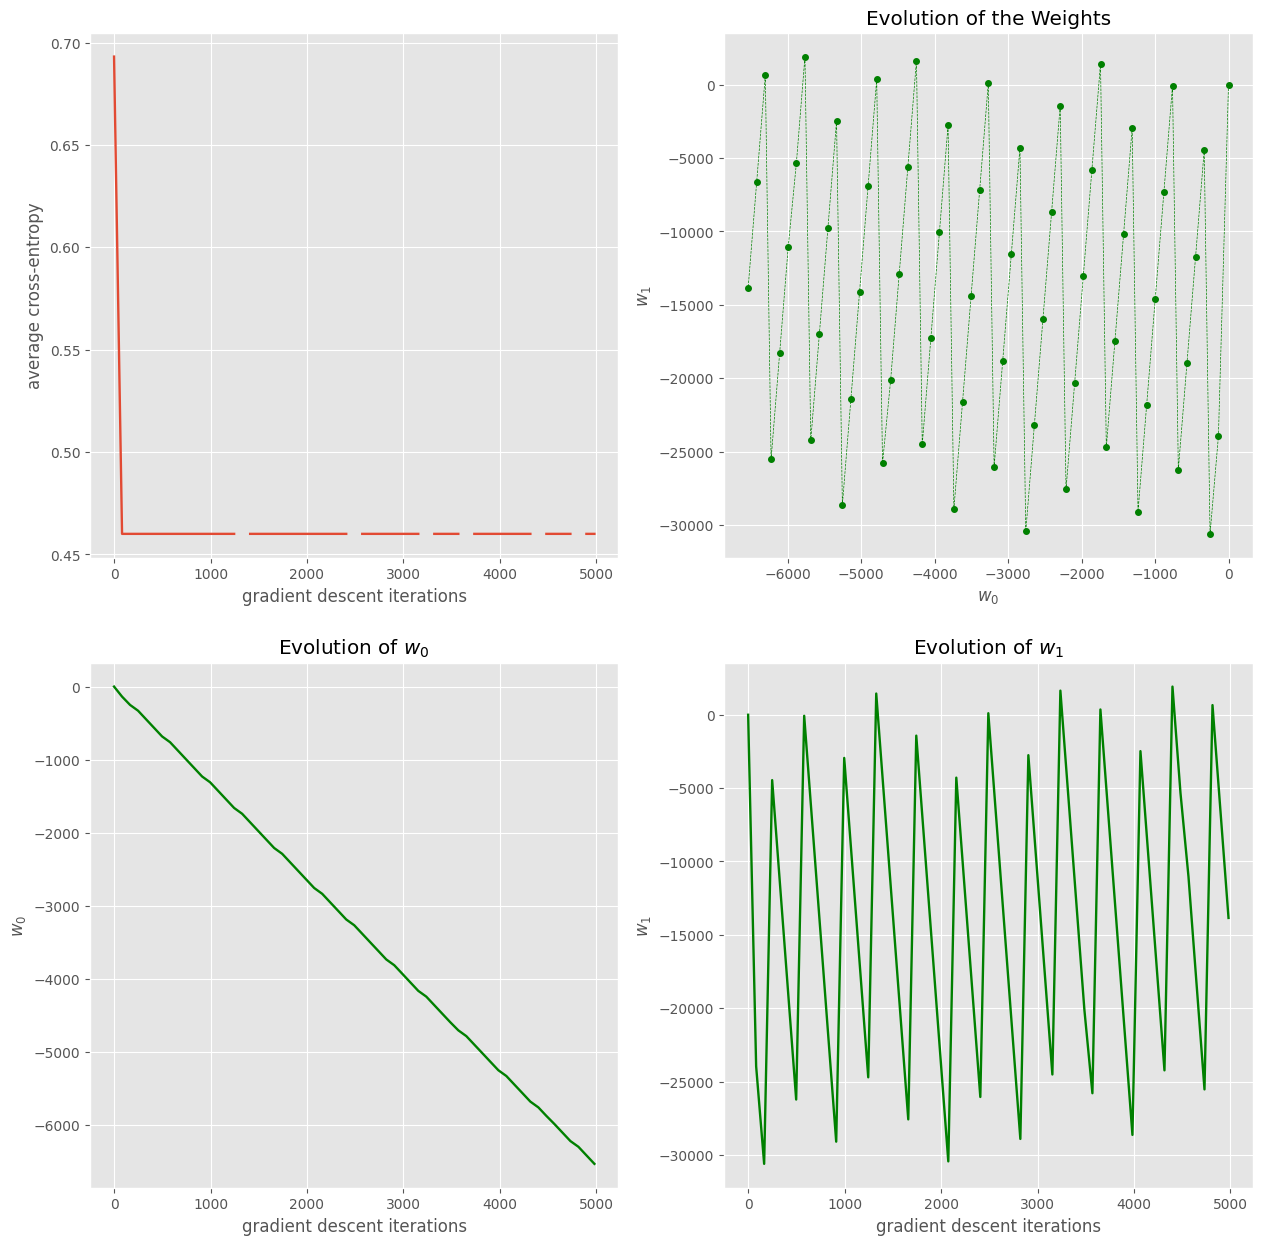

In [41]:
# plotting the evloution of loss + weights

plot_loss_graph_and_weight_evolution(loss, ws, its)

# we can see that the weights are diverging



starting gradient descent


100%|██████████| 5000/5000 [00:04<00:00, 1220.72it/s]


[-13.84210076   6.43279817]


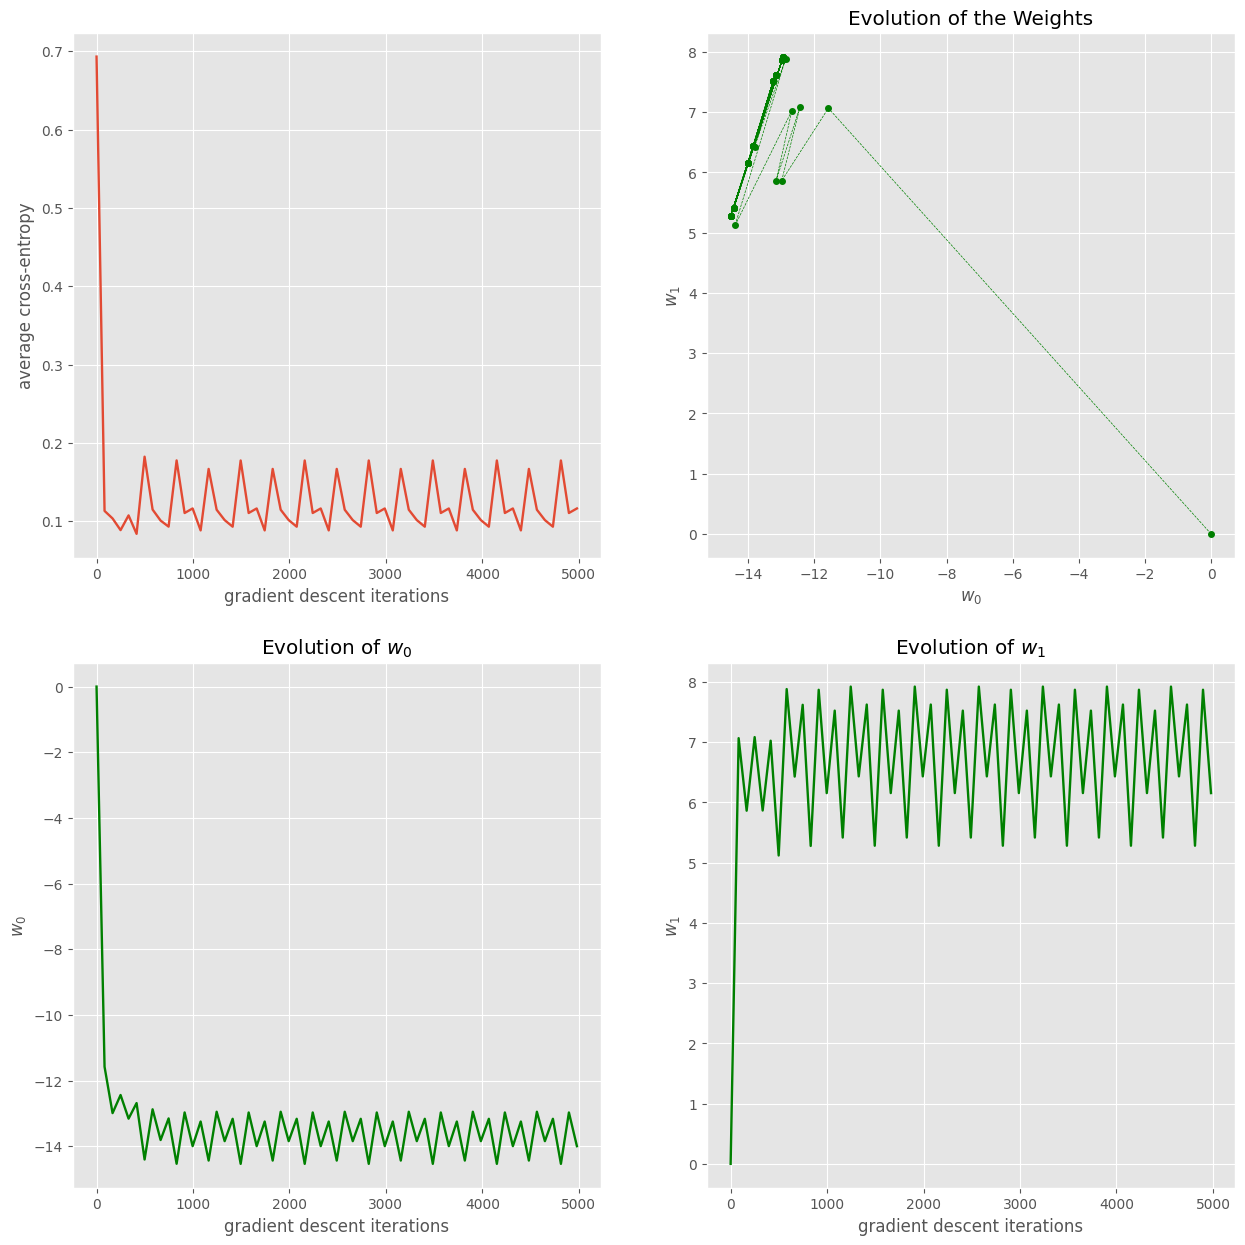

In [42]:
# One problem here is that Gradient Descent algorithms are quite sensitive
# to initial conditions and it is often beneficial to rescale or offset
# the features to improve the performance.
#
# In our case we note that balance ranges from 0 to about 2500.
# this is much larger in magnitude to the first feature which is simply 1.
# Thus we (arbitrarily) rescale by factor of 1/1000

X[:,1] = balance[:]/1000;

# note to self: we'll need to apply this rescaling
# everytime we are making predictions.

# starting again Gradient Descent with same parameters
w, loss, its, ws = gradient_descent(w0, X, y, learning_rate=40, maxit=5000);
print(w)

# plot of the loss graph
plot_loss_graph_and_weight_evolution(loss, ws, its)



In [43]:
# we can see that we are doing much better, with the loss going down to about an
# avg cross entropy of 0.1, but it still seems to be oscillating,
# which indicates that the learning rate is probably too high (see lecture notes)

In [44]:
# note that you can also check if you reached convergence by checking if the
# gradient is null (or at least very small):
# Import lab_2 again
importlib.reload(lab_2)

print(lab_2.gradient(w, X, y))

[-0.02182854 -0.03596885]


learning rate = 60
starting gradient descent


100%|██████████| 3000/3000 [00:02<00:00, 1246.03it/s]


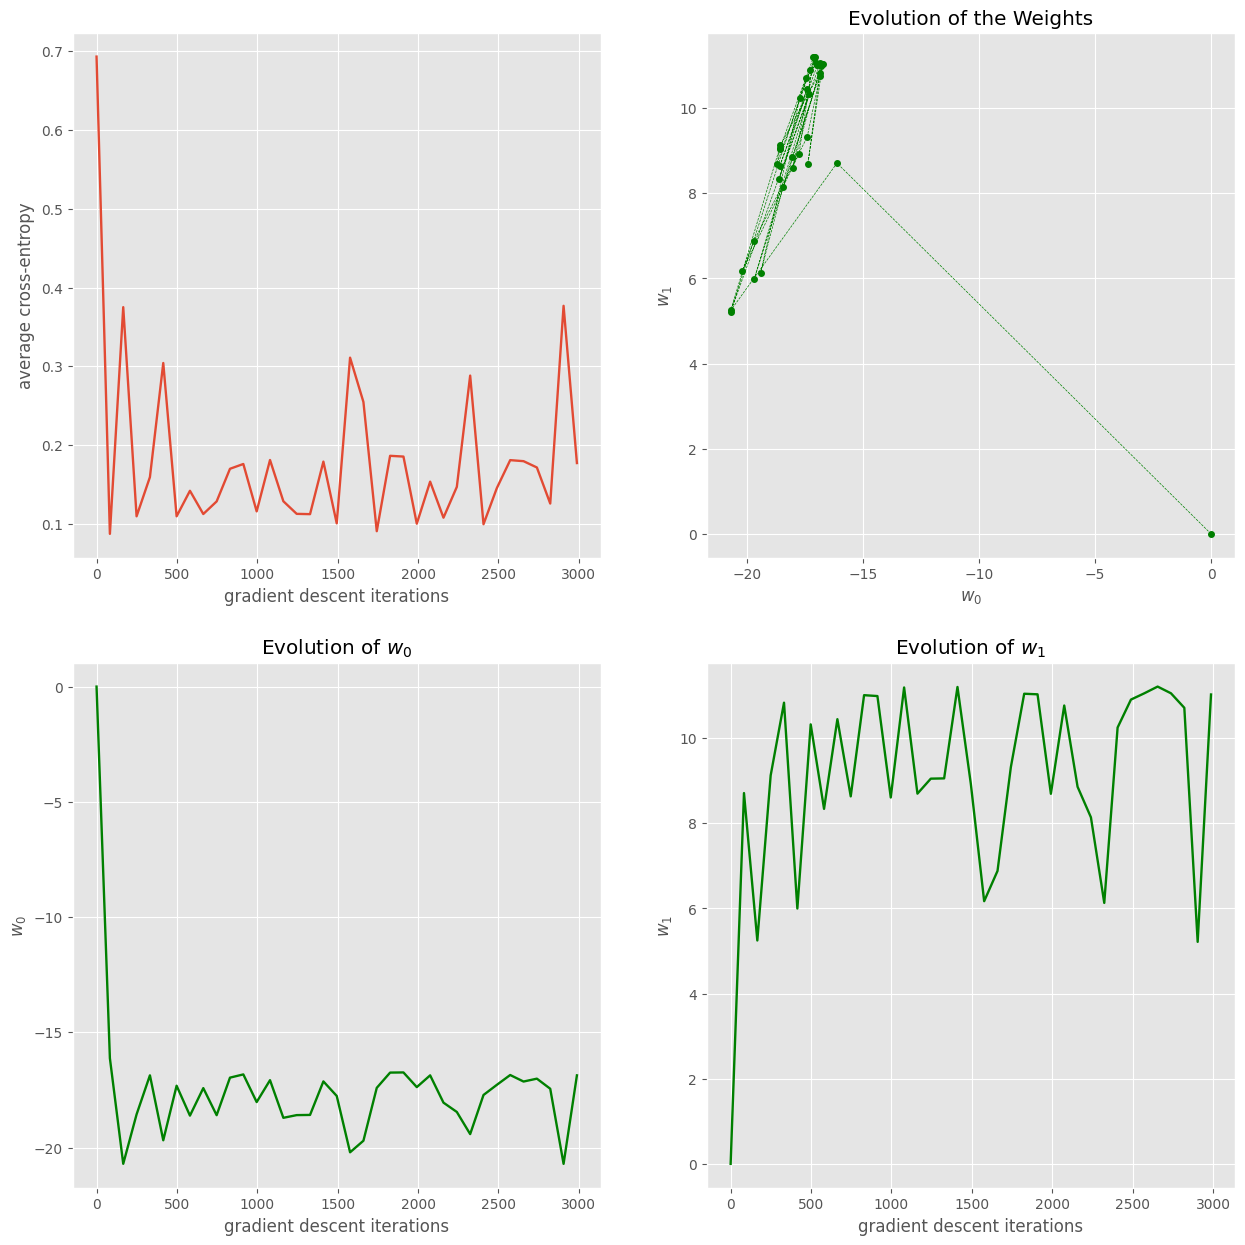

In [50]:
# Exercise: study the convergence for a few different learning rates,
# and observe the different behaviours.
# for instance you can try lr values in {150, 30, 10, 1, 0.001}

lr = 60 # change learning rate here
w0 = np.array([0,0]);
print(f"learning rate = {lr}")
w, loss, its, ws = gradient_descent(w0, X, y, learning_rate=lr, maxit=3000);
plot_loss_graph_and_weight_evolution(loss, ws, its)

# Question 3
# Find the learning rate that allows us to converge the fastest to the global optimum.
# eg. lr = 45 (doesn't have to be super precise, push to assessment to check if answer is ok)
# write answer in question_3 of lab_2.py


In [ ]:
# In logistic Regression, we set a parametric model for the likelihood
# we denote logit = x'w and parametrise the likelihood as
# p(y_i=1|logit) = 1/(1 + exp(-logit))
#
# We want to verify that this is a correct approximation for our problem
#
# The following function makes an empirical measurement of p(y_i=1|logit)
# by recording in the dataset the proportion of default=True for
# a particular logit value (within some small threshold T=1).

# Import lab_2 again
importlib.reload(lab_2)

def get_empirical_likelihood(logit, logits_train, y):
    # selecting all logits in training set that are +/- 0.5 of given logit
    valid = ((logits_train < logit + 0.5) & (logits_train > logit - 0.5));
    n_positives = sum(valid[y==True]);
    n_negatives = sum(valid[y==False]);
    empirical_likelihood = n_positives / (n_positives  + n_negatives);
    return empirical_likelihood


# taking an ok value for w:
w = np.array([-10.63971053,   5.49188453])

# testing set consists of regularly sampled 100 values of balance
n_test = 100
X_test = np.zeros(shape=(n_test,2))
X_test[0:n_test,0] = 1;
X_test[0:n_test,1] = np.linspace(X[:,1].min(), X[:,1].max(), num=n_test)

# making predictions for these values
p_test = lab_2.predict(w, X_test)

# we compute the logit values and their corresponding empirical probabilities of default
logits_test = lab_2.logit(w, X_test)
logits_train = lab_2.logit(w, X)
p_empirical = [get_empirical_likelihood(logit, logits_train, y)
                  for logit in logits_test ];

# plot the graphs

plt.scatter(X[y==False,1], y[y==False], alpha= 0.2)
plt.scatter(X[y==True,1], y[y==True], alpha= 0.2)
plt.plot(X_test[:,1], p_test, color='black')
plt.plot(X_test[:,1], p_empirical, ':', color='gray')

plt.ylabel('Probability of default');
plt.xlabel('Balance');
plt.yticks([0, 0.25, 0.5, 0.75, 1.]);
plt.legend(['logistic model for probability of default',
            'empirically measured probability of default\n(within a +/- 0.5 logit bin)',
            'No Default', 'Default'],  prop={'size': 12})
plt.show()

# you should be able to see that the logistic model is not a bad approximation
# of the empirical likelihood


In [ ]:
# Import lab_2 again
importlib.reload(lab_2)

# At this point, we still don't have a classifier.
# All we need is to set a threshold on the predicted probabilities

# #### EXERCISE 4 ####
# In lab_2.py, write a function 'predict_class' in the module to give
# the predicted class for observations X and weights w.

# Use that function here to assess the accuracy of the classifier
# for different thresholds.

# Accuracy = percentage correctly classified.
def accuracy(w, X, y, threshold):
    return np.mean(y == lab_2.predict_class(w, X, threshold))

# taking an ok value for w:
w = np.array([-10.63971053,   5.49188453])

print("Accuracy for T=0.25: {}".format(accuracy(w, X, y, threshold=0.25)))
print("Accuracy for T=0.50: {}".format(accuracy(w, X, y, threshold=0.5)))
print("Accuracy for T=0.75: {}".format(accuracy(w, X, y, threshold=0.75)))
print("Accuracy for T=0.95: {}".format(accuracy(w, X, y, threshold=0.95)))

# #### EXERCISE 5 ####
# in lab_2.py, update function 'question_5' to
# return the accuracy for a threshold of 0.75

# Multinomial Logistic Regression



In [ ]:
# Let's now see how to work with more than 2 classes.
# loading the Iris dataset.
# This is a foumous 3-classes dataset, from Fisher, 1936

from sklearn.datasets import load_iris
iris = load_iris()
print(iris['DESCR'])


In [ ]:
# let's explore the dataset
# as we have 4 features, we will break down the visualisation into pairs of
# features

X = iris.data
Y = iris.target
class_names = iris.target_names
feature_names = iris.feature_names

df = pd.DataFrame(X, columns=iris.feature_names)

grr = pd.plotting.scatter_matrix(df, c=Y, figsize=(12, 12),grid=True,
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)


In [ ]:
# we are going to split the dataset into training and test tests in a 70/30 ratio

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.3, random_state = 11)


In [ ]:
# this time we'll use off-the-shelf functions to get the optimisation

log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial',random_state = 11)
log_reg.fit(trainX, trainY)
y_pred = log_reg.predict(testX)

In [ ]:
print('Accuracy:   {:.2f}'.format(np.mean(testY ==  y_pred)))
print('Error rate: {:.2f}'.format(1 - np.mean(testY ==  y_pred)))


In [ ]:
# #### EXERCISE 6 ####
#
# Quiz-style: return the bias in weight vector associated with logit of class=0
#
# hint: biases can be obtained from log_reg.intercept_
#       and the other coefficients from log_reg.coef_.


In [ ]:
# In multinomial logistic regression, we have one score/logit per class
# the logit is obtained from its own weight vector.
# We propose here to visualise the score/logit map for each of the classes.

# the point of this cell is for you to visualise what the score maps do
# just try different class ids and on different feature pairs.

classid = 2; # you can change this to 0,1,2

# Plot the risk score map (x'w_k) for the associated class weights vector w_k.
featx = 1 # feat 0 will be on x-axis, you can change this to 0,1,2,3
featy = 2 # feat 1 will be on y-axis, you can change this to 0,1,2,3

# getting area of interest

x_min = trainX[:,featx].min()
x_max = trainX[:,featx].max()
y_min = trainX[:,featy].min()
y_max = trainX[:,featy].max()

# grid sampling the feature space
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 256), np.linspace(y_min, y_max, 256))

# making prediction for point on grid
Z = log_reg.coef_[classid,featx] * xx + yy * log_reg.coef_[classid,featy]

# plot score map
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, levels=10, alpha=0.9)
# overlay dataset points
scatter = plt.scatter(trainX[:, featx], trainX[:, featy], c=(trainY==classid), alpha=0.8)

kw = scatter.legend_elements()
kw[1][0] = f"other classes"
kw[1][1] = f"class {classid} ({class_names[classid]})"
plt.legend(*kw)

plt.xlabel(f"Feature {featx} - {feature_names[featx]}")
plt.ylabel(f"Feature {featy} - {feature_names[featy]}")
plt.title(f"risk score map for class {classid} ({class_names[classid]})")
plt.show()




In [ ]:
# #### EXERCISE 7 ####
#
# In this exercise, you must find the best pair of features in the iris dataset.
#
# To find this pair, you will consider every possible pair and reduce the
# input features to only that pair (and ignore the other two features).
#
# hint:
# iterate through all possible pairs and for each pair:
# 1. modify both training and test sets to only include the two considered features
# 2. train a multinomial logistic regression model based on this reduced feature set
# 3. make prediction on the reduced test set
# 4. report accuracy for that pair
#
# you can work in this notebook, but you need to report the best pair
# and the accuracy in question_7 in lab_2.py

# You might need to do `importlib.reload(lab_1)` to reload labs_2 if you have
# modfied any functions in it.

